In [1]:
# Refer to this part of the code: https://github.com/gitesei/willard-chandler/blob/master/WCIS_functions.py
import numpy as np
import pandas as pd
import mdtraj as md
from scipy.spatial import cKDTree
from skimage import measure
import sys
from time import time
import itertools
import matplotlib.pyplot as plt
def make_grid(box,mesh):
    ngrid = np.ceil(box / mesh).astype(int)
    grid_shape = tuple(ngrid.astype(int))
    spacing = box / ngrid
    xyz = []
    for i in range(3):
        xyz.append(np.linspace(0., box[i]-box[i]/ngrid[i], ngrid[i]))
    x, y, z = np.meshgrid(xyz[0], xyz[1], xyz[2], indexing='ij')
    grid = np.c_[x.reshape(-1, 1), y.reshape(-1, 1), z.reshape(-1, 1)]
    return grid, spacing, grid_shape


def initialize(filename,top,mesh,alpha,molecules,nskip,layers):
    #load traj
    sel = ' or '.join(['name '+m for mol in molecules for m in mol.split(' ') if m[0]!='H'])
    traj = md.load_dcd(filename,top=top,
            atom_indices=top.top.select(sel))[nskip:]
    box = traj.unitcell_lengths.mean(0)  
    atom_indices=top.top.select(sel)

        #atom density distrubation along z axis
    #print(box)
    #print(traj.xyz[:,:,2])
    hist, edges = np.histogram(traj.xyz[:,:,2],bins=np.arange(0,box[2],1).astype(int))  
    #hist, edges = np.histogram(traj.xyz[:,:,2],bins=np.arange(0,box[2],0.1))  
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1]*traj.n_frames)
    plt.plot(hist)
    z_min = np.floor(z[hist>hist.max()/2].min()).astype(int)
    z_max = np.ceil(z[hist>hist.max()/2].max()).astype(int)
    # max and min density biger than half density
    #z_min = np.floor(z[hist>hist.max()/2].min())
    #z_max = np.ceil(z[hist>hist.max()/2].max())
    #print(z_min)
    #print(z_max)
    #print("hist",hist)
    #print(z_min+2,z_max-2)
    # get the position where half density is (GBS point)
    level = 0.5*hist[np.logical_and(z>z_min+1,z<z_max-1)].mean()
    edges = np.arange(-1,z_max-z_min+1,mesh*0.1)
    z = edges[:-1]+(edges[1]-edges[0])/2.
    thetaedges = np.arange(0,181,2)
    theta = thetaedges[:-1]+(thetaedges[1]-thetaedges[0])/2.
    grid, spacing, grid_shape = make_grid(box,mesh)
    data = {}
    # initialization data
    for molecule in molecules:
        atoms = molecule.split(' ')
        if len(atoms)==1:
            #data[atoms[0]] = {'upper': np.zeros(z.size), 'lower': np.zeros(z.size)} 
            data[atoms[0]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)), all=np.empty(0), ndang=np.empty(0)), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)), all=np.empty(0), ndang=np.empty(0))}
        elif len(atoms)==3:
            for atom in atoms[::2]:
                data[atom] = {'upper': np.zeros(z.size), 'lower': np.zeros(z.size)}
            data[atoms[1]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms[::2], theta=np.zeros((len(layers)-1,theta.size))), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms[::2], theta=np.zeros((len(layers)-1,theta.size)))}
        elif len(atoms)==2:
            data[atoms[0]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros(theta.size), all=np.empty(0), ndang=np.empty(0)), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros(theta.size), all=np.empty(0), ndang=np.empty(0))}
            data[atoms[1]] = {'upper': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size))), 
                              'lower': dict(cosine=np.zeros(z.size), conc=np.zeros(z.size), 
                                pair=atoms, theta=np.zeros((len(layers)-1,theta.size)))}
    params = {"radius": 3*alpha,
             "scale": 2.*alpha**2,
             "factor": np.power(2.*np.pi*alpha**2,-3/2.),
             "box": box,
             "mesh": mesh,
             "bw": mesh*0.1,
             "n_frames": traj.n_frames+nskip,
             "spacing": spacing,
             "grid": grid,
             "grid_shape": grid_shape,
             "edges": edges,
             "theta": theta,
             "z": z,
             "sel": sel,
             "surface_area": np.empty(0),
             "surface_zstd": np.empty(0),
             "level": level,
             "layers": layers,
             "data": data}
    del traj
    return pd.Series(params)

def calc_profiles(frame,surface,params,label,sign,layers):
    box, edges, data, bw = params['box'], params['edges'], params['data'], params['bw']
    toM = 1. / (bw*box[0]*box[1]*6.022*0.1)
    verts, normals = surface
    tree = cKDTree(verts, boxsize=box)
    for atom, value in data.items():
        pos = frame.atom_slice(frame.top.select('name '+atom)).xyz[0]
        #pos = frame.atom_slice(frame.top.select('name O')).xyz[0]
        #print('pos',pos)
        _, ind = tree.query(pos, k=1)
        dist = (tree.data[ind,2] - pos[:,2])*sign
        if type(value[label]) == dict:
            hist, _ = np.histogram(dist,bins=edges,density=False)
            value[label]['conc'] += hist * toM
            if value[label]['theta'].ndim > 1:
            #    cosine(frame,dist,atom,normals[ind,:],value[label],sign,edges,toM,layers)
            #else:
                selOSN = frame.top.select('name O or name O1')
                posOSN = frame.atom_slice(selOSN).xyz[0]
                _, indOSN = tree.query(posOSN, k=1)
                distOSN = (tree.data[indOSN,2] - posOSN[:,2])*sign
                mask = np.logical_and(dist>-.31,dist<.31)#rqz influence dangling number
                idx = np.asarray(frame.top.select('name O'))[mask]

                ind_surf = ind[mask]
                mask = np.logical_and(distOSN>-.8,distOSN<0.8)#rqz influence dangling number
                idxOSN = np.asarray(selOSN)[mask]
                #print('idx',idx)
                #print('idx',idx)
                #print('dist',dist)
                dangling(frame,value[label],sign,dist,distOSN,idx,idxOSN,normals[ind_surf,:])     
        else:
            # hist of density distrubation with distance from WCI
            hist, _ = np.histogram(dist,bins=edges,density=False)
            value[label] += hist * toM
def cosine(frame,dist,atom,normals,dictionary,sign,edges,toM,layers):
    selection_string = 'name O or name H1'
    pair1 = np.array(frame.top.select(selection_string)).reshape(-1,2)
    vec1 = md.compute_displacements(frame,pair).reshape(-1,3)
    selection_string = 'name O or name H2'
    pair2 = np.array(frame.top.select(selection_string)).reshape(-1,2)
    vec2 = md.compute_displacements(frame,pair2).reshape(-1,3)
    vec=vec1+vec2
    
    cosine = np.einsum('ij,ij->i',vec,normals) / np.linalg.norm(vec,axis=1)
    if atom=='C2':
        cosine = -cosine
    #hist, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    cosine_sum, _ = np.histogram(dist,bins=edges,weights=cosine,density=False)
    bin_count, _ = np.histogram(dist, bins=edges)
    bin_count = np.where(bin_count == 0, 1, bin_count)
    cosine_avg = cosine_sum / bin_count
    hist=cosine_avg
    dictionary['cosine'] += hist * toM
    angle = np.arccos(np.clip(cosine,-1,1))/np.pi*180
    for i in range(len(layers)-1):
        mask = np.logical_and(dist>layers[i],dist<layers[i+1])
        hist, _ = np.histogram(angle[mask],bins=np.arange(0,181,2),density=False)
        dictionary['theta'][i] += hist


def dangling(frame,dictionary,sign,dist,distOSN,idx,idxOSN,normals):
    # idx:  O index near interface 
    #idxOSN: O index to define O-O distance and then for selecting dang OH 
    pair_ox = np.asarray(list(itertools.product(idx, idxOSN)))
    # remove pairs of same index
    pair_ox = pair_ox[np.std(pair_ox,axis=1)!=0]
    dist_ox = md.compute_distances(frame,pair_ox).reshape(idx.size,-1)
    h1o = np.c_[idx,idx+1]
    h2o = np.c_[idx,idx+2]
    # compute H-O vectors
    vec_h1o = md.compute_displacements(frame,h1o).reshape(-1,3)
    vec_h2o = md.compute_displacements(frame,h2o).reshape(-1,3)
    cosine_h1o = np.einsum('ij,ij->i',vec_h1o,normals) / np.linalg.norm(vec_h1o,axis=1)
    cosine_h2o = np.einsum('ij,ij->i',vec_h2o,normals) / np.linalg.norm(vec_h2o,axis=1)
    angle_h1o = np.arccos(np.clip(cosine_h1o,-1,1))/np.pi*180
    angle_h2o = np.arccos(np.clip(cosine_h2o,-1,1))/np.pi*180
    h1ox = np.c_[np.asarray(pair_ox)[:,0]+1,np.asarray(pair_ox)[:,0],np.asarray(pair_ox)[:,1]]
    h2ox = np.c_[np.asarray(pair_ox)[:,0]+2,np.asarray(pair_ox)[:,0],np.asarray(pair_ox)[:,1]]
    # compute H-O...O angles
    angle_h1ox = md.compute_angles(frame,h1ox).reshape(idx.size,-1)/np.pi*180
    angle_h2ox = md.compute_angles(frame,h2ox).reshape(idx.size,-1)/np.pi*180
    # selection of dangling OH based on R-beta definition (DOI: 10.1021/acs.jctc.7b00566)
    Rc = dist_ox<=.35
    
    beta1 = angle_h1ox<=50
    beta2 = angle_h2ox<=50
    angles_ho = np.append(angle_h1o[np.sum(beta1*Rc,axis=1)==0],angle_h2o[np.sum(beta2*Rc,axis=1)==0])
    #print(idx)   #index oxygen near interface 
    #print("ndang index1",idx[np.sum(beta1*Rc,axis=1)==0]) #dang index H1-O...O
    #print("ndang index2",idx[np.sum(beta2*Rc,axis=1)==0]) #dang index H2-O...O
    dictionary['ndang'] = np.append(dictionary['ndang'],angles_ho.size)
    dictionary['all'] = np.append(dictionary['all'],idx.size)
    hist, _ = np.histogram(angles_ho,bins=np.arange(0,181,2),density=False)
    dictionary['theta'] += hist

def find_isosurfaces(frame,params):
    radius,factor,scale,sel = params['radius'],params['factor'],params['scale'],params['sel']
    level = params['level']
    params['box'] = frame.unitcell_lengths[0]
    
    box=params['box']
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0][:,2]
    hist, edges = np.histogram(pos,bins=np.arange(0,box[2],1).astype(int)) 
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1])
    z_min = np.floor(z[hist>hist.max()/2].min()).astype(int)
    z_max = np.ceil(z[hist>hist.max()/2].max()).astype(int)
    #print("hist",hist)
    #print(z_min+2,z_max-2)
    # get the position where half density is (GBS point)
    level = 0.5*hist[np.logical_and(z>z_min+1,z<z_max-1)].mean()
    #print('level',level)
    '''
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0][:,2]
    pos = pos[(pos >= z_min-0.5) & (pos <= z_max+0.5)] 
    hist, edges = np.histogram(pos,bins=np.arange(z_min-0.5,z_max+0.5,0.1))  
    z = edges[:-1]+(edges[1]-edges[0])/2.
    hist = hist/(box[0]*box[1])
    plt.plot(z,hist)
    
    '''
    interface_to_air_width = 1.5  # interface to air width
    interface_to_bulk_width = 2.0  # interface to bulk width
    #print(z_min - interface_to_air_width,z_min + interface_to_bulk_width)
    #print(z_max - interface_to_bulk_width,z_max + interface_to_air_width)
    z_min_air = z_min - interface_to_air_width
    z_min_bulk = z_min + interface_to_bulk_width
    z_max_bulk = z_max - interface_to_bulk_width
    z_max_air = z_max + interface_to_air_width
    z_min_air = max(z_min_air, 0)
    z_max_air = min(z_max_air, box[2])
    params['grid'],params['spacing'],params['grid_shape'] = make_grid(params['box'],params['mesh'])
    grid,spacing,grid_shape,box = params['grid'],params['spacing'],params['grid_shape'],params['box']
    #print(spacing)
    #print(grid_shape)
    # limit z 
    pos = frame.atom_slice(frame.top.select('name O')).xyz[0]
    interface_to_air_width = 0.5  # interface to air width
    
    #print(z_min - interface_to_air_width,z_min + interface_to_bulk_width)
    #print(z_max - interface_to_bulk_width,z_max + interface_to_air_width)
    #pos = pos[((pos[:, 2] >= z_min - interface_to_air_width) & (pos[:, 2] <= z_min + interface_to_bulk_width)) |
    #      ((pos[:, 2] >= z_max - interface_to_bulk_width) & (pos[:, 2] <= z_max + interface_to_air_width))]
    #pos = pos[(pos[:, 2] >= z_min-interface_to_air_width) & (pos[:, 2] <= z_max+interface_to_air_width) ]   
    tree = cKDTree(grid,boxsize=box)
                
    # indeces of grid points within a radial distance from the particles
    indlist = tree.query_ball_point(pos, radius)

    # unwrapped list of lists
    indarray = np.asarray(list(itertools.chain.from_iterable(indlist)),dtype=int)

    # lenghts of the sublists in indlist
    lenarray = np.asarray([len(ind) for ind in indlist],dtype=int)

    # vector distance between particles and grid points
    dr = grid[indarray,:] - np.repeat(pos, lenarray, axis=0)

    # periodic boundary conditions in xy-plane
    cond = np.where(np.abs(dr) > box / 2.)
    dr[cond] -= np.sign(dr[cond])*box[cond[1]]
    # coarse grained density field
    dens = factor*np.exp( - np.linalg.norm(dr,ord=2,axis=1)**2 / scale )
    # densities at the same grid point are summed up
    field = pd.DataFrame(data={'index': indarray, 'dens': dens}).groupby('index').sum()
    # grid points with zero density are included in the dataframe
    new_index = pd.Index(range(grid.shape[0]), name="index")
    field = field.reindex(new_index,fill_value=0).values.reshape(grid_shape)
    
    verts, faces, normals, values = measure.marching_cubes(field, level, spacing=tuple(spacing))
    verts[:,:2] = verts[:,:2] + spacing[:2] / 2.
    cond_upper = verts[:,2]>box[2]/2
    
   
    upper = verts[cond_upper], normals[cond_upper]
    lower = verts[~cond_upper], normals[~cond_upper]
    
    params['surface_area'] = np.append(params['surface_area'],measure.mesh_surface_area(verts,faces)*0.5)
    params['surface_zstd'] = np.append(params['surface_zstd'],upper[0][:,2].std())
    params['surface_zstd'] = np.append(params['surface_zstd'],lower[0][:,2].std())
    return upper, lower



water_PMMA.dcd water_PMMA.pdb
frame:  0
frame:  1
frame:  2
frame:  3
frame:  4
frame:  5
frame:  6
frame:  7
frame:  8
frame:  9
frame:  10
frame:  11
frame:  12
frame:  13
frame:  14
frame:  15
frame:  16
frame:  17
frame:  18
frame:  19


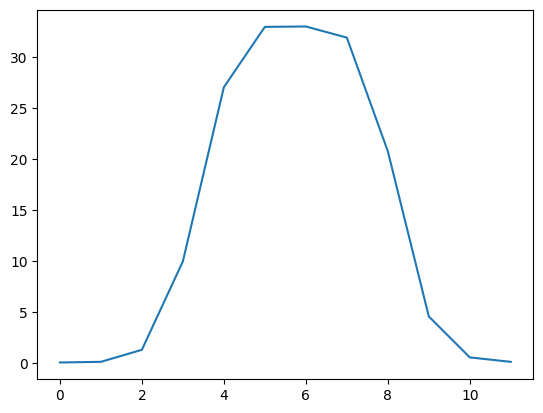

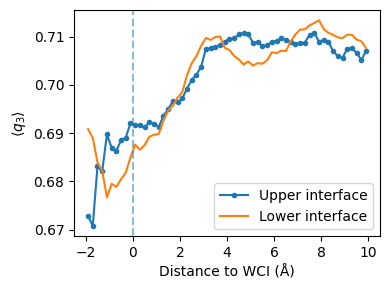

In [7]:
import json, time, os
import numpy as np

def _prepare_from_res(res, extra_meta=None):
    edges = np.asarray(res["edges_A"])
    centers = np.asarray(res.get("centers_A", 0.5*(edges[:-1]+edges[1:])))
    U_cnt = np.asarray(res["U_cnt"], dtype=np.int64)
    L_cnt = np.asarray(res["L_cnt"], dtype=np.int64)
    U_sum = np.asarray(res.get("U_sum", np.asarray(res["U_mean"], float)*U_cnt), float)
    L_sum = np.asarray(res.get("L_sum", np.asarray(res["L_mean"], float)*L_cnt), float)
    U_sum2 = np.asarray(res.get("U_sum2", np.full_like(U_sum, np.nan)), float)
    L_sum2 = np.asarray(res.get("L_sum2", np.full_like(L_sum, np.nan)), float)
    meta = {
        "format": "q3_vs_WCI_v1",
        "bin_width_A": float(np.diff(edges)[0]) if len(edges)>1 else np.nan,
        "dist_min_A": float(edges[0]),
        "dist_max_A": float(edges[-1]),
        "units": {"distance":"Å","q3":"dimensionless"},
    }
    if isinstance(extra_meta, dict):
        meta.update(extra_meta)
    return edges, centers, U_sum, U_cnt, U_sum2, L_sum, L_cnt, L_sum2, meta

def save_q3_res_multi(res, out_path, fmt="npz", extra_meta=None):
    edges, centers, U_sum, U_cnt, U_sum2, L_sum, L_cnt, L_sum2, meta = _prepare_from_res(res, extra_meta)
    fmt = fmt.lower()
    base, ext = os.path.splitext(out_path)
    if fmt == "npz":
        if ext.lower() != ".npz": out_path = base + ".npz"
        np.savez_compressed(out_path,
            edges_A=edges, centers_A=centers,
            U_sum=U_sum, U_cnt=U_cnt, U_sum2=U_sum2,
            L_sum=L_sum, L_cnt=L_cnt, L_sum2=L_sum2,
            meta=json.dumps(meta))
        return out_path
    elif fmt == "csv":
        import pandas as pd
        df = pd.DataFrame({
            "edge_left_A": edges[:-1], "edge_right_A": edges[1:], "center_A": centers,
            "U_sum": U_sum, "U_cnt": U_cnt, "U_sum2": U_sum2,
            "L_sum": L_sum, "L_cnt": L_cnt, "L_sum2": L_sum2,
        })
        if ext.lower() != ".csv": out_path = base + ".csv"
        df.to_csv(out_path, index=False)
        with open(base + "_meta.json", "w") as f:
            json.dump(meta, f, indent=2)
        return out_path


    elif fmt == "hdf5" or fmt == "h5":
        import h5py
        if ext.lower() not in (".h5", ".hdf5"): out_path = base + ".h5"
        with h5py.File(out_path, "w") as f:
            g = f.create_group("q3_vs_WCI")
            g.create_dataset("edges_A", data=edges, compression="gzip", compression_opts=4)
            g.create_dataset("centers_A", data=centers, compression="gzip", compression_opts=4)
            g.create_dataset("U_sum", data=U_sum, compression="gzip", compression_opts=4)
            g.create_dataset("U_cnt", data=U_cnt, compression="gzip", compression_opts=4)
            g.create_dataset("U_sum2", data=U_sum2, compression="gzip", compression_opts=4)
            g.create_dataset("L_sum", data=L_sum, compression="gzip", compression_opts=4)
            g.create_dataset("L_cnt", data=L_cnt, compression="gzip", compression_opts=4)
            g.create_dataset("L_sum2", data=L_sum2, compression="gzip", compression_opts=4)
            f.attrs["meta"] = json.dumps(meta)
        return out_path

    else:
        raise ValueError("fmt must be one of: 'npz', 'csv', 'parquet', 'hdf5'")

import numpy as np
import mdtraj as md
import freud
from freud.locality import AABBQuery
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull

import numpy as np
import freud
from freud.locality import AABBQuery

def q3_freud_all_O(frame,
                         center_sel='name O',         
                         neighbor_sel='name O or name O1 or name Cl or name CEN or name S ',  
                         nn=3):
    """
    return:
      q3      : (N_center,)   
      d3_A    : (N_center,)   distance 
      Cpos_A  : (N_center,3)  center (Å)
      boxA    : (3,)          box length
    """
    # --- 选中心与邻居 ---
    idx_c = frame.top.select(center_sel)
    idx_n = frame.top.select(neighbor_sel)

    Cpos_nm = frame.atom_slice(idx_c).xyz[0]      # nm
    Npos_nm = frame.atom_slice(idx_n).xyz[0]      # nm
    Cpos_A  = Cpos_nm * 10.0                      # Å
    Npos_A  = Npos_nm * 10.0                      # Å
    boxA    = frame.unitcell_lengths[0] * 10.0    # Å 

    fbox = freud.box.Box.from_box(boxA)         
    aq   = AABBQuery(fbox, Npos_A)
    nlist = aq.query(Cpos_A, {'num_neighbors': nn+1}).toNeighborList()

    qind = nlist.query_point_indices     # [0..N_center)
    pind = nlist.point_indices           # [0..N_neighbor)

    disp = fbox.wrap(Npos_A[pind] - Cpos_A[qind])   # (M,3)
    dist = np.linalg.norm(disp, axis=1)             # (M,)

    same = (idx_n[pind] == idx_c[qind])
    if np.any(same):
        disp = disp[~same]
        dist = dist[~same]
        qind = qind[~same]
        pind = pind[~same]

    order = np.lexsort((dist, qind))
    qind = qind[order]; dist = dist[order]; disp = disp[order]

    nC = len(idx_c)
    q3   = np.full(nC, np.nan, float)
    d3_A = np.full(nC, np.nan, float)

    starts = np.searchsorted(qind, np.arange(nC), side='left')
    ends   = np.searchsorted(qind, np.arange(nC), side='right')

    for c in range(nC):
        s, e = starts[c], ends[c]
        m = e - s
        if m < nn:
            continue
        vecs = disp[s:s+nn]       
        d3_A[c] = dist[s+nn-1]      

        vhat = vecs / np.linalg.norm(vecs, axis=1, keepdims=True)
        cos6 = []
        for j in range(nn-1):
            for k in range(j+1, nn):
                cos6.append(np.dot(vhat[j], vhat[k]))
        cos6 = np.asarray(cos6)
        S = np.sum((cos6 + 1.0/3.0)**2)
        q3[c] = 1.0 - 6.0/8.0 * S

    return q3, d3_A, Cpos_A, boxA

def bin_q3_vs_surface(Opos_A, q3, d3, surface, sign, edges_A, d3_max_A=3.5):
   
    verts_nm, _ = surface
    verts_A = verts_nm * 10.0
    nb = len(edges_A) - 1
    sum_bins  = np.zeros(nb, float)
    cnt_bins  = np.zeros(nb, int)

    tree = cKDTree(verts_A)
    _, ind = tree.query(Opos_A, k=1)
    dist_A = (verts_A[ind, 2] - Opos_A[:, 2]) * sign   

    valid = np.isfinite(q3) & (d3 < d3_max_A)

    which = np.digitize(dist_A[valid], edges_A) - 1
    m = (which >= 0) & (which < nb)
    which = which[m]; qv = q3[valid][m]

    np.add.at(sum_bins, which, qv)
    np.add.at(cnt_bins, which, 1)
    return sum_bins, cnt_bins

def q3_profile_freud_vs_WCI(dcd_name, top, params,
                            dist_min_A=-2.0, dist_max_A=10.0, binw_A=0.2,
                            d3_max_A=3.5, start=0, stride=1):
    edges_A   = np.arange(dist_min_A, dist_max_A + binw_A, binw_A)
    centers_A = 0.5*(edges_A[:-1] + edges_A[1:])
    nb = len(edges_A) - 1

    U_sum = np.zeros(nb); U_cnt = np.zeros(nb, int)
    L_sum = np.zeros(nb); L_cnt = np.zeros(nb, int)

    upperS = []; lowerS = []

    for i in range(start, params['n_frames'], stride):
        print("frame: ",i)
        frame = md.load_frame(dcd_name, index=i, top=top)

        upper, lower = find_isosurfaces(frame, params)   # (verts, normals) in nm
        upperS.append(upper[0]); lowerS.append(lower[0])

        hull_upper = ConvexHull(upper[0])
        upper_surface_area = hull_upper.area
    
        hull_lower = ConvexHull(lower[0])
        lower_surface_area = hull_lower.area
        if abs(upper_surface_area-lower_surface_area) < (lower_surface_area+upper_surface_area)*0.1:

            q3, d3, Opos_A, _ = q3_freud_all_O(frame, nn=3)
    
            sU, cU = bin_q3_vs_surface(Opos_A, q3, d3, upper, sign=+1, edges_A=edges_A, d3_max_A=d3_max_A)
            sL, cL = bin_q3_vs_surface(Opos_A, q3, d3, lower, sign=-1, edges_A=edges_A, d3_max_A=d3_max_A)
    
            U_sum += sU; U_cnt += cU
            L_sum += sL; L_cnt += cL

        else: print("wrong surface:",upper_surface_area,lower_surface_area ,i)
    U_mean = np.divide(U_sum, U_cnt, out=np.full(nb, np.nan), where=U_cnt>0)
    L_mean = np.divide(L_sum, L_cnt, out=np.full(nb, np.nan), where=L_cnt>0)

    return dict(centers_A=centers_A,
                U_mean=U_mean, U_cnt=U_cnt,
                L_mean=L_mean, L_cnt=L_cnt,
                edges_A=edges_A)

def weighted_moving_average(mean, count, k_bins=7):
    kernel = np.ones(k_bins)
    num = np.convolve(mean*count, kernel, mode='same')
    den = np.convolve(count,      kernel, mode='same')
    return num / np.where(den>0, den, np.nan)

def plot_q3_profile(res, smooth_bins=7, min_count=30):
    x = res['centers_A']
    U_mean, U_cnt = res['U_mean'], res['U_cnt']
    L_mean, L_cnt = res['L_mean'], res['L_cnt']

    Um = np.where(U_cnt>=min_count, U_mean, np.nan)
    Lm = np.where(L_cnt>=min_count, L_mean, np.nan)

    if smooth_bins and smooth_bins>1:
        Um_s = weighted_moving_average(Um, U_cnt, k_bins=smooth_bins)
        Lm_s = weighted_moving_average(Lm, L_cnt, k_bins=smooth_bins)
    else:
        Um_s, Lm_s = Um, Lm

    plt.figure(figsize=(4,3))
    plt.plot(x, Um_s, '-o', ms=3, label='Upper interface')
    plt.plot(x, Lm_s, '-',  label='Lower interface')
    plt.axvline(0.0, ls='--', alpha=0.5)
    plt.xlabel('Distance to WCI (Å)')
    plt.ylabel(r'$\langle q_3 \rangle$')
    plt.tight_layout()
    plt.legend()
    plt.show()



dcd_name="water_PMMA.dcd"
top_name="water_PMMA.pdb"
print(dcd_name,top_name)
top = md.load(top_name)
params = initialize(filename=dcd_name,top=top,mesh=0.2,alpha=0.3,
            molecules=['O'],nskip=0,layers=[-0.1,0.1,0.3,0.5])
res=q3_profile_freud_vs_WCI(dcd_name=dcd_name, top=top, params=params,start=0)
out_path='q3'
save_q3_res_multi(res, out_path, fmt="npz", extra_meta=None)
save_q3_res_multi(res, out_path, fmt="csv", extra_meta=None)
plot_q3_profile(res, smooth_bins=10, min_count=1)
